In [2]:
"""
Science Frame Calibration Script for NGC 1365
Applies bias, dark, and flat field corrections with cosmic ray rejection
"""

import os
import numpy as np
from astropy.io import fits
from astropy.nddata import CCDData
from ccdproc import ImageFileCollection, subtract_bias, subtract_dark, flat_correct, cosmicray_lacosmic
import astropy.units as u
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION
# ============================================================================

# Base directory
BASE_DIR = "/home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19"

# Input directories for science frames
SCIENCE_DIRS = {
    'clear': os.path.join(BASE_DIR, "NGC1365clear"),
    'r': os.path.join(BASE_DIR, "NGC1365r"),
    'i': os.path.join(BASE_DIR, "NGC1365i"),
    'g': os.path.join(BASE_DIR, "NGC1365g")
}

# Calibration frame paths
MASTER_BIAS = os.path.join(BASE_DIR, "BIAS", "master_bias_combined.fits")
MASTER_DARK = os.path.join(BASE_DIR, "DARK60S", "master_dark_60s.fits")

MASTER_FLATS = {
    'clear': os.path.join(BASE_DIR, "Image_reduction_workspace/master_flats", "master_flat_clear.fits"),
    'r': os.path.join(BASE_DIR, "Image_reduction_workspace/master_flats", "master_flat_r.fits"),
    'i': os.path.join(BASE_DIR, "Image_reduction_workspace/master_flats", "master_flat_i.fits"),
    'g': os.path.join(BASE_DIR, "Image_reduction_workspace/master_flats", "master_flat_g.fits")
}

# Output directory
OUTPUT_DIR = os.path.join(BASE_DIR, "Image_reduction_workspace/LIGHT")

# Cosmic ray rejection parameters
CR_SIGCLIP = 4.5  # Sigma clipping threshold
CR_SIGFRAC = 0.3  # Fractional detection limit
CR_OBJLIM = 5.0   # Contrast limit between CR and underlying object

# ============================================================================
# FUNCTIONS
# ============================================================================

def load_master_calibration_frame(filepath, frame_type):
    """Load master calibration frame"""
    print(f"Loading {frame_type}: {filepath}")
    try:
        data = CCDData.read(filepath, unit=u.adu)
        print(f"  ✓ {frame_type} loaded successfully - Shape: {data.shape}")
        return data
    except Exception as e:
        print(f"  ✗ Error loading {frame_type}: {e}")
        raise

def calibrate_science_frame(science_file, master_bias, master_dark, master_flat, 
                           output_dir, filter_name, apply_cosmic_ray=True):
    """
    Calibrate a single science frame
    Steps: Bias subtraction -> Dark subtraction -> Flat correction -> CR rejection
    """
    try:
        # Load science frame
        science = CCDData.read(science_file, unit=u.adu)
        
        # Step 1: Bias subtraction
        science = subtract_bias(science, master_bias)
        
        # Step 2: Dark subtraction
        science = subtract_dark(science, master_dark, 
                               exposure_time='exptime', exposure_unit=u.second,
                               scale=True)
        
        # Step 3: Flat field correction
        science = flat_correct(science, master_flat)
        
        # Step 4: Cosmic ray rejection
        if apply_cosmic_ray:
            # FIX: cosmicray_lacosmic returns 3 values, not 2
            science_cr = cosmicray_lacosmic(
                science, 
                sigclip=CR_SIGCLIP,
                sigfrac=CR_SIGFRAC,
                objlim=CR_OBJLIM,
                verbose=False
            )
            # The function returns a tuple; the first element is the cleaned CCDData
            science = science_cr[0] if isinstance(science_cr, tuple) else science_cr
        
        # Save calibrated frame
        base_name = os.path.basename(science_file)
        output_name = base_name.replace('.fit', '_calibrated.fits')
        output_path = os.path.join(output_dir, filter_name, output_name)
        
        science.write(output_path, overwrite=True)
        
        return True, output_name
        
    except Exception as e:
        return False, str(e)
       
def process_filter(filter_name, science_dir, master_bias, master_dark, master_flat, output_dir):
    """Process all science frames for a given filter"""
    
    print(f"\n{'='*70}")
    print(f"Processing filter: {filter_name.upper()}")
    print(f"{'='*70}")
    
    # Create output subdirectory for this filter
    filter_output_dir = os.path.join(output_dir, filter_name)
    os.makedirs(filter_output_dir, exist_ok=True)
    print(f"Output directory: {filter_output_dir}")
    
    # Get list of science frames
    if not os.path.exists(science_dir):
        print(f"✗ Science directory not found: {science_dir}")
        return
    
    science_files = sorted([f for f in os.listdir(science_dir) if f.endswith('.fit')])
    
    if len(science_files) == 0:
        print(f"✗ No .fit files found in {science_dir}")
        return
    
    print(f"Found {len(science_files)} science frames")
    
    # Process each frame
    success_count = 0
    fail_count = 0
    
    for i, filename in enumerate(science_files, 1):
        filepath = os.path.join(science_dir, filename)
        print(f"\n[{i}/{len(science_files)}] Processing: {filename}")
        
        success, result = calibrate_science_frame(
            filepath, master_bias, master_dark, master_flat,
            output_dir, filter_name, apply_cosmic_ray=True
        )
        
        if success:
            print(f"  ✓ Successfully calibrated -> {result}")
            success_count += 1
        else:
            print(f"  ✗ Failed: {result}")
            fail_count += 1
    
    # Summary
    print(f"\n{'-'*70}")
    print(f"Filter {filter_name.upper()} Summary:")
    print(f"  Successfully processed: {success_count}")
    print(f"  Failed: {fail_count}")
    print(f"{'-'*70}")

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    print("\n" + "="*70)
    print("NGC 1365 SCIENCE FRAME CALIBRATION")
    print("="*70)
    
    # Create main output directory
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    print(f"\nMain output directory: {OUTPUT_DIR}")
    
    # Load master calibration frames
    print("\n" + "="*70)
    print("LOADING MASTER CALIBRATION FRAMES")
    print("="*70)
    
    master_bias = load_master_calibration_frame(MASTER_BIAS, "Master Bias")
    master_dark = load_master_calibration_frame(MASTER_DARK, "Master Dark")
    
    master_flats = {}
    for filt, flat_path in MASTER_FLATS.items():
        master_flats[filt] = load_master_calibration_frame(flat_path, f"Master Flat ({filt})")
    
    # Process each filter
    for filter_name, science_dir in SCIENCE_DIRS.items():
        process_filter(
            filter_name, 
            science_dir, 
            master_bias, 
            master_dark, 
            master_flats[filter_name],
            OUTPUT_DIR
        )
    
    # Final summary
    print("\n" + "="*70)
    print("CALIBRATION COMPLETE!")
    print("="*70)
    print(f"\nCalibrated frames saved in: {OUTPUT_DIR}")
    print("\nDirectory structure:")
    for filt in SCIENCE_DIRS.keys():
        filt_dir = os.path.join(OUTPUT_DIR, filt)
        if os.path.exists(filt_dir):
            count = len([f for f in os.listdir(filt_dir) if f.endswith('.fits')])
            print(f"  {filt}/  ({count} files)")
    print("\n")

if __name__ == "__main__":
    main()


NGC 1365 SCIENCE FRAME CALIBRATION

Main output directory: /home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19/Image_reduction_workspace/LIGHT

LOADING MASTER CALIBRATION FRAMES
Loading Master Bias: /home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19/BIAS/master_bias_combined.fits
  ✓ Master Bias loaded successfully - Shape: (2048, 2048)
Loading Master Dark: /home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19/DARK60S/master_dark_60s.fits
  ✓ Master Dark loaded successfully - Shape: (2048, 2048)
Loading Master Flat (clear): /home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19/Image_reduction_workspace/master_flats/master_flat_clear.fits
  ✓ Master Flat (clear) loaded successfully - Shape: (2048, 2048)
Loading Master Flat (r): /home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19/Image_reduction_workspace/master_flats/master_flat_r.fits
  ✓ Master Flat (r) loaded successfully - Shape: (2048, 2048


CALIBRATION VERIFICATION VISUALIZATION

Output directory: /home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19/Image_reduction_workspace/calibration_checks

Loading files...
  Raw file: NGC1365-0001_2x2_60s.fit
  Calibrated file: NGC1365-0001_2x2_60s_calibrated.fits
  ✓ Files loaded successfully


RAW FRAME Statistics:
  Mean:      1374.48
  Median:    1365.00
  Std Dev:   348.02
  Min:       1189.00
  Max:       65535.00
  Negative:  0 pixels (0.000%)

CALIBRATED FRAME Statistics:
  Mean:      356.66
  Median:    349.15
  Std Dev:   329.30
  Min:       -3805.67
  Max:       66383.13
  Negative:  93 pixels (0.002%)

Creating visualizations...

[1/3] Comprehensive comparison plot...

✓ Saved PNG: /home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19/Image_reduction_workspace/calibration_checks/NGC1365-0001_2x2_60s_comparison.png
✓ Saved TIFF: /home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19/Image_reduction_workspace/calibration_c

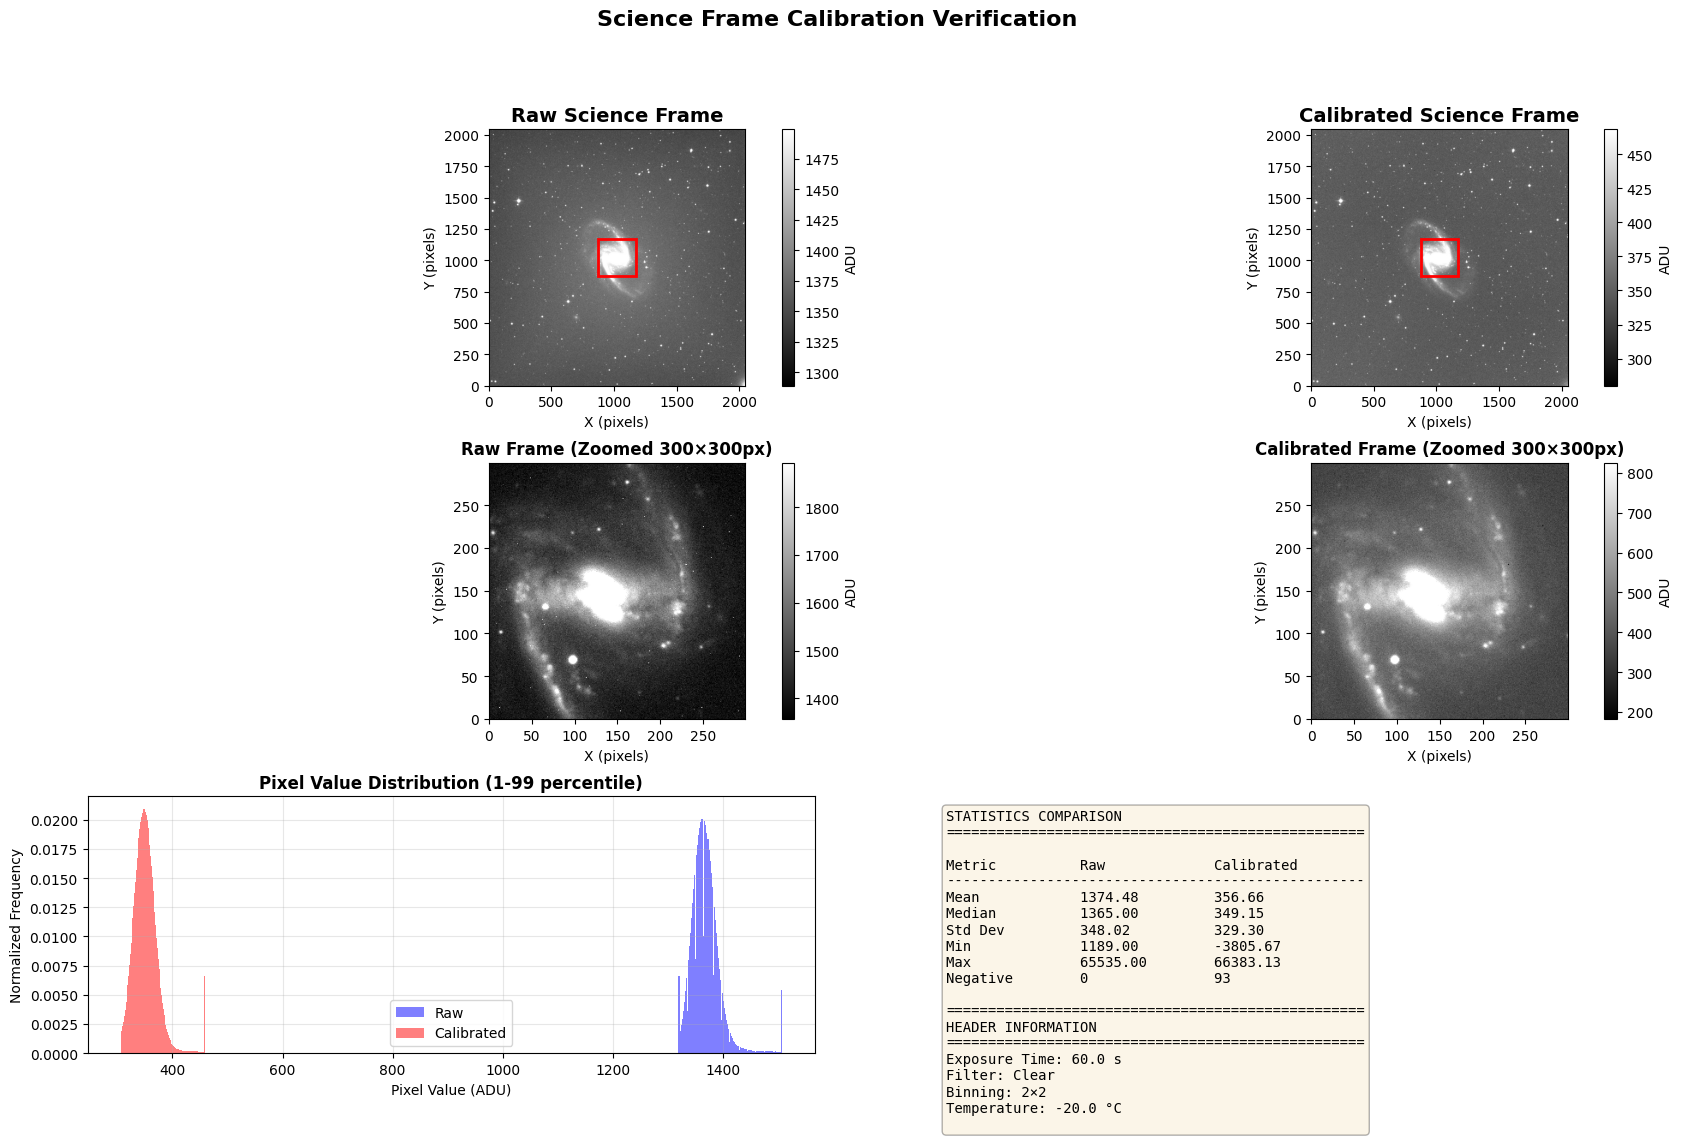


[2/3] Simple side-by-side comparison...
✓ Saved simple PNG: /home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19/Image_reduction_workspace/calibration_checks/NGC1365-0001_2x2_60s_simple.png
✓ Saved simple TIFF: /home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19/Image_reduction_workspace/calibration_checks/NGC1365-0001_2x2_60s_simple.tif


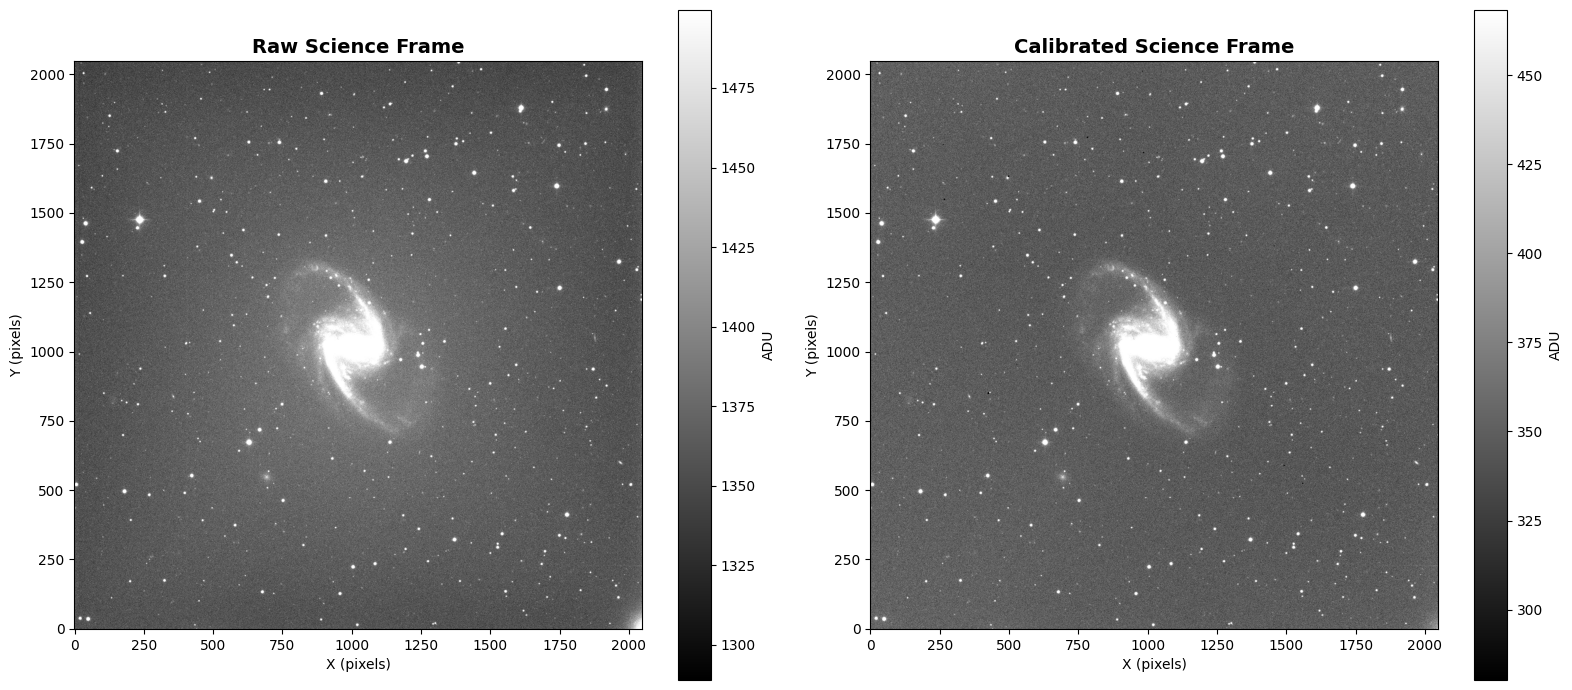


[3/3] Difference image...
✓ Saved difference PNG: /home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19/Image_reduction_workspace/calibration_checks/NGC1365-0001_2x2_60s_difference.png
✓ Saved difference TIFF: /home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19/Image_reduction_workspace/calibration_checks/NGC1365-0001_2x2_60s_difference.tif


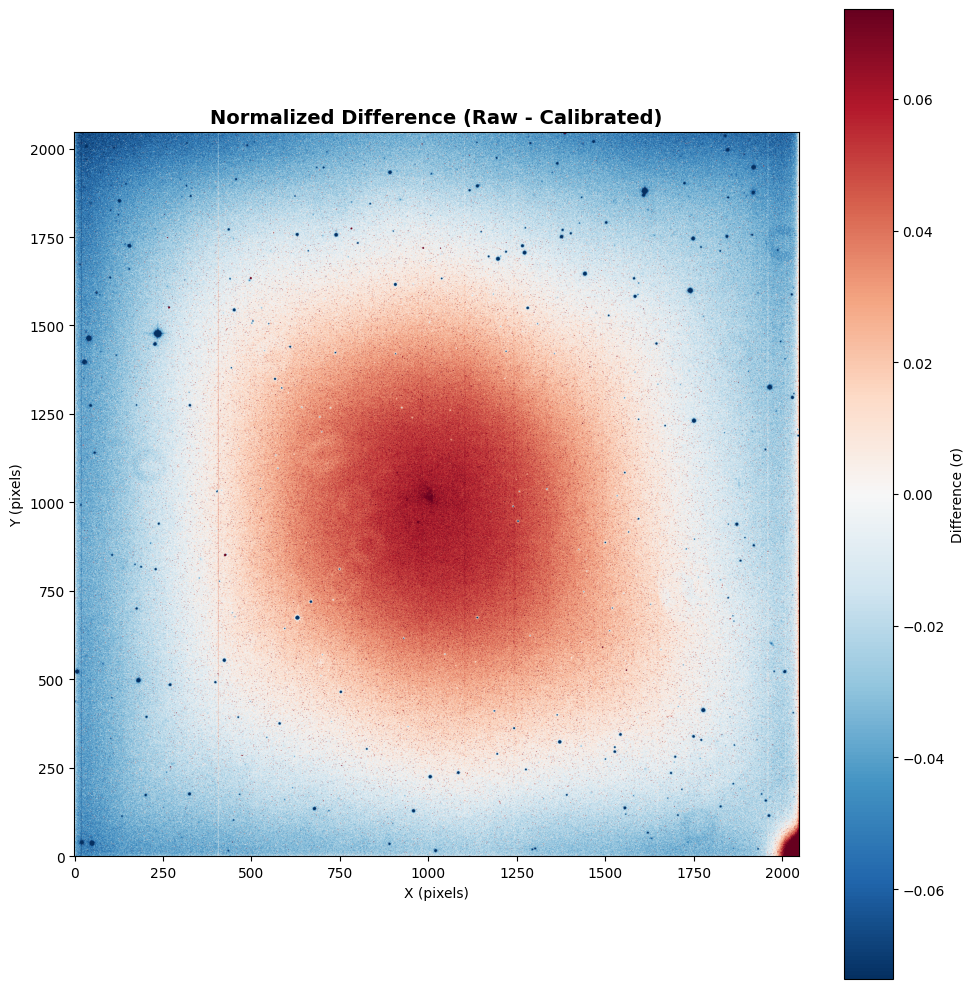


VISUALIZATION COMPLETE!

All files saved in: /home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19/Image_reduction_workspace/calibration_checks

Files created:
  • NGC1365-0001_2x2_60s_comparison.png (comprehensive)
  • NGC1365-0001_2x2_60s_comparison.tif (comprehensive)
  • NGC1365-0001_2x2_60s_simple.png (side-by-side)
  • NGC1365-0001_2x2_60s_simple.tif (side-by-side)
  • NGC1365-0001_2x2_60s_difference.png (difference)
  • NGC1365-0001_2x2_60s_difference.tif (difference)




In [3]:
"""
Calibration Verification Visualization Script
Compares raw and calibrated science frames side-by-side
Saves as PNG and displays statistics
"""

import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import ZScaleInterval, ImageNormalize, LinearStretch, AsinhStretch
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION
# ============================================================================

# Base directory
BASE_DIR = "/home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19"

# Example files to compare (change these to your actual files)
RAW_FILE = os.path.join(BASE_DIR, "NGC1365clear", "NGC1365-0001_2x2_60s.fit")
CALIBRATED_FILE = os.path.join(BASE_DIR, "Image_reduction_workspace/LIGHT/clear", 
                               "NGC1365-0001_2x2_60s_calibrated.fits")

# Output directory for comparison images
OUTPUT_DIR = os.path.join(BASE_DIR, "Image_reduction_workspace", "calibration_checks")

# Visualization parameters
ZOOM_SIZE = 300  # Size of zoomed region in pixels
ZOOM_CENTER = (1024, 1024)  # Center of zoom region (change to interesting area)

# ============================================================================
# FUNCTIONS
# ============================================================================

def load_fits_data(filepath):
    """Load FITS file and return data array"""
    with fits.open(filepath) as hdul:
        data = hdul[0].data.astype(float)
        header = hdul[0].header
    return data, header

def calculate_statistics(data, label=""):
    """Calculate and print image statistics"""
    stats = {
        'mean': np.mean(data),
        'median': np.median(data),
        'std': np.std(data),
        'min': np.min(data),
        'max': np.max(data),
        'negative_pixels': np.sum(data < 0),
        'negative_percent': 100 * np.sum(data < 0) / data.size
    }
    
    print(f"\n{label} Statistics:")
    print(f"  Mean:      {stats['mean']:.2f}")
    print(f"  Median:    {stats['median']:.2f}")
    print(f"  Std Dev:   {stats['std']:.2f}")
    print(f"  Min:       {stats['min']:.2f}")
    print(f"  Max:       {stats['max']:.2f}")
    print(f"  Negative:  {stats['negative_pixels']} pixels ({stats['negative_percent']:.3f}%)")
    
    return stats

def create_comparison_figure(raw_data, cal_data, raw_header, cal_header, output_prefix):
    """
    Create comprehensive comparison visualization
    """
    
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)
    
    # Use ZScale for better visualization
    zscale = ZScaleInterval()
    
    # Get common vmin/vmax for fair comparison
    vmin_raw, vmax_raw = zscale.get_limits(raw_data)
    vmin_cal, vmax_cal = zscale.get_limits(cal_data)
    
    # ========================================================================
    # Row 1: Full frame comparison
    # ========================================================================
    
    # Raw frame
    ax1 = fig.add_subplot(gs[0, 0:2])
    im1 = ax1.imshow(raw_data, cmap='gray', origin='lower', 
                     vmin=vmin_raw, vmax=vmax_raw)
    ax1.set_title('Raw Science Frame', fontsize=14, fontweight='bold')
    ax1.set_xlabel('X (pixels)')
    ax1.set_ylabel('Y (pixels)')
    plt.colorbar(im1, ax=ax1, label='ADU', fraction=0.046)
    
    # Add zoom box indicator
    rect = mpatches.Rectangle((ZOOM_CENTER[0] - ZOOM_SIZE//2, ZOOM_CENTER[1] - ZOOM_SIZE//2),
                              ZOOM_SIZE, ZOOM_SIZE, linewidth=2, 
                              edgecolor='red', facecolor='none')
    ax1.add_patch(rect)
    
    # Calibrated frame
    ax2 = fig.add_subplot(gs[0, 2:4])
    im2 = ax2.imshow(cal_data, cmap='gray', origin='lower',
                     vmin=vmin_cal, vmax=vmax_cal)
    ax2.set_title('Calibrated Science Frame', fontsize=14, fontweight='bold')
    ax2.set_xlabel('X (pixels)')
    ax2.set_ylabel('Y (pixels)')
    plt.colorbar(im2, ax=ax2, label='ADU', fraction=0.046)
    
    # Add zoom box indicator
    rect2 = mpatches.Rectangle((ZOOM_CENTER[0] - ZOOM_SIZE//2, ZOOM_CENTER[1] - ZOOM_SIZE//2),
                               ZOOM_SIZE, ZOOM_SIZE, linewidth=2,
                               edgecolor='red', facecolor='none')
    ax2.add_patch(rect2)
    
    # ========================================================================
    # Row 2: Zoomed comparison
    # ========================================================================
    
    x_start = ZOOM_CENTER[0] - ZOOM_SIZE//2
    x_end = ZOOM_CENTER[0] + ZOOM_SIZE//2
    y_start = ZOOM_CENTER[1] - ZOOM_SIZE//2
    y_end = ZOOM_CENTER[1] + ZOOM_SIZE//2
    
    raw_zoom = raw_data[y_start:y_end, x_start:x_end]
    cal_zoom = cal_data[y_start:y_end, x_start:x_end]
    
    vmin_zoom_raw, vmax_zoom_raw = zscale.get_limits(raw_zoom)
    vmin_zoom_cal, vmax_zoom_cal = zscale.get_limits(cal_zoom)
    
    # Raw zoom
    ax3 = fig.add_subplot(gs[1, 0:2])
    im3 = ax3.imshow(raw_zoom, cmap='gray', origin='lower',
                     vmin=vmin_zoom_raw, vmax=vmax_zoom_raw)
    ax3.set_title(f'Raw Frame (Zoomed {ZOOM_SIZE}×{ZOOM_SIZE}px)', 
                  fontsize=12, fontweight='bold')
    ax3.set_xlabel('X (pixels)')
    ax3.set_ylabel('Y (pixels)')
    plt.colorbar(im3, ax=ax3, label='ADU', fraction=0.046)
    
    # Calibrated zoom
    ax4 = fig.add_subplot(gs[1, 2:4])
    im4 = ax4.imshow(cal_zoom, cmap='gray', origin='lower',
                     vmin=vmin_zoom_cal, vmax=vmax_zoom_cal)
    ax4.set_title(f'Calibrated Frame (Zoomed {ZOOM_SIZE}×{ZOOM_SIZE}px)', 
                  fontsize=12, fontweight='bold')
    ax4.set_xlabel('X (pixels)')
    ax4.set_ylabel('Y (pixels)')
    plt.colorbar(im4, ax=ax4, label='ADU', fraction=0.046)
    
    # ========================================================================
    # Row 3: Histograms and statistics
    # ========================================================================
    
    # Histogram comparison
    ax5 = fig.add_subplot(gs[2, 0:2])
    
    # Clip extreme values for better histogram visualization
    raw_clip = np.clip(raw_data, np.percentile(raw_data, 1), 
                       np.percentile(raw_data, 99))
    cal_clip = np.clip(cal_data, np.percentile(cal_data, 1),
                       np.percentile(cal_data, 99))
    
    ax5.hist(raw_clip.flatten(), bins=100, alpha=0.5, label='Raw', 
             color='blue', density=True)
    ax5.hist(cal_clip.flatten(), bins=100, alpha=0.5, label='Calibrated',
             color='red', density=True)
    ax5.set_xlabel('Pixel Value (ADU)')
    ax5.set_ylabel('Normalized Frequency')
    ax5.set_title('Pixel Value Distribution (1-99 percentile)', fontsize=12, fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # Statistics text box
    ax6 = fig.add_subplot(gs[2, 2:4])
    ax6.axis('off')
    
    # Calculate statistics
    raw_stats = {
        'Mean': np.mean(raw_data),
        'Median': np.median(raw_data),
        'Std Dev': np.std(raw_data),
        'Min': np.min(raw_data),
        'Max': np.max(raw_data),
        'Negative': np.sum(raw_data < 0)
    }
    
    cal_stats = {
        'Mean': np.mean(cal_data),
        'Median': np.median(cal_data),
        'Std Dev': np.std(cal_data),
        'Min': np.min(cal_data),
        'Max': np.max(cal_data),
        'Negative': np.sum(cal_data < 0)
    }
    
    stats_text = "STATISTICS COMPARISON\n" + "="*50 + "\n\n"
    stats_text += f"{'Metric':<15} {'Raw':<15} {'Calibrated':<15}\n"
    stats_text += "-"*50 + "\n"
    
    for key in raw_stats.keys():
        if key == 'Negative':
            stats_text += f"{key:<15} {raw_stats[key]:<15.0f} {cal_stats[key]:<15.0f}\n"
        else:
            stats_text += f"{key:<15} {raw_stats[key]:<15.2f} {cal_stats[key]:<15.2f}\n"
    
    # Add header information
    stats_text += "\n" + "="*50 + "\n"
    stats_text += "HEADER INFORMATION\n" + "="*50 + "\n"
    stats_text += f"Exposure Time: {raw_header.get('EXPTIME', 'N/A')} s\n"
    stats_text += f"Filter: {raw_header.get('FILTER', 'N/A')}\n"
    stats_text += f"Binning: {raw_header.get('XBINNING', 'N/A')}×{raw_header.get('YBINNING', 'N/A')}\n"
    stats_text += f"Temperature: {raw_header.get('CCD-TEMP', 'N/A')} °C\n"
    
    ax6.text(0.05, 0.95, stats_text, transform=ax6.transAxes,
             fontsize=10, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    # Overall title
    fig.suptitle('Science Frame Calibration Verification', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # Save as PNG
    png_path = f"{output_prefix}_comparison.png"
    plt.savefig(png_path, dpi=150, bbox_inches='tight')
    print(f"\n✓ Saved PNG: {png_path}")
    
    # Save as TIFF
    tif_path = f"{output_prefix}_comparison.tif"
    plt.savefig(tif_path, dpi=150, bbox_inches='tight', format='tiff')
    print(f"✓ Saved TIFF: {tif_path}")
    
    plt.show()
    
    return fig

def create_simple_side_by_side(raw_data, cal_data, output_prefix):
    """
    Create simple side-by-side comparison
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    zscale = ZScaleInterval()
    vmin_raw, vmax_raw = zscale.get_limits(raw_data)
    vmin_cal, vmax_cal = zscale.get_limits(cal_data)
    
    # Raw
    im1 = ax1.imshow(raw_data, cmap='gray', origin='lower',
                     vmin=vmin_raw, vmax=vmax_raw)
    ax1.set_title('Raw Science Frame', fontsize=14, fontweight='bold')
    ax1.set_xlabel('X (pixels)')
    ax1.set_ylabel('Y (pixels)')
    plt.colorbar(im1, ax=ax1, label='ADU')
    
    # Calibrated
    im2 = ax2.imshow(cal_data, cmap='gray', origin='lower',
                     vmin=vmin_cal, vmax=vmax_cal)
    ax2.set_title('Calibrated Science Frame', fontsize=14, fontweight='bold')
    ax2.set_xlabel('X (pixels)')
    ax2.set_ylabel('Y (pixels)')
    plt.colorbar(im2, ax=ax2, label='ADU')
    
    plt.tight_layout()
    
    # Save
    png_path = f"{output_prefix}_simple.png"
    plt.savefig(png_path, dpi=150, bbox_inches='tight')
    print(f"✓ Saved simple PNG: {png_path}")
    
    tif_path = f"{output_prefix}_simple.tif"
    plt.savefig(tif_path, dpi=150, bbox_inches='tight', format='tiff')
    print(f"✓ Saved simple TIFF: {tif_path}")
    
    plt.show()

def create_difference_image(raw_data, cal_data, output_prefix):
    """
    Create difference image to highlight changes
    """
    # Normalize both images to same scale for comparison
    raw_norm = (raw_data - np.mean(raw_data)) / np.std(raw_data)
    cal_norm = (cal_data - np.mean(cal_data)) / np.std(cal_data)
    
    difference = raw_norm - cal_norm
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    # Use symmetric colormap centered at zero
    vmax = np.percentile(np.abs(difference), 99)
    im = ax.imshow(difference, cmap='RdBu_r', origin='lower',
                   vmin=-vmax, vmax=vmax)
    ax.set_title('Normalized Difference (Raw - Calibrated)', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('X (pixels)')
    ax.set_ylabel('Y (pixels)')
    cbar = plt.colorbar(im, ax=ax, label='Difference (σ)')
    
    plt.tight_layout()
    
    # Save
    png_path = f"{output_prefix}_difference.png"
    plt.savefig(png_path, dpi=150, bbox_inches='tight')
    print(f"✓ Saved difference PNG: {png_path}")
    
    tif_path = f"{output_prefix}_difference.tif"
    plt.savefig(tif_path, dpi=150, bbox_inches='tight', format='tiff')
    print(f"✓ Saved difference TIFF: {tif_path}")
    
    plt.show()

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    print("\n" + "="*70)
    print("CALIBRATION VERIFICATION VISUALIZATION")
    print("="*70)
    
    # Create output directory
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    print(f"\nOutput directory: {OUTPUT_DIR}")
    
    # Load data
    print("\nLoading files...")
    print(f"  Raw file: {os.path.basename(RAW_FILE)}")
    print(f"  Calibrated file: {os.path.basename(CALIBRATED_FILE)}")
    
    try:
        raw_data, raw_header = load_fits_data(RAW_FILE)
        cal_data, cal_header = load_fits_data(CALIBRATED_FILE)
        print("  ✓ Files loaded successfully")
    except Exception as e:
        print(f"  ✗ Error loading files: {e}")
        return
    
    # Calculate statistics
    print("\n" + "="*70)
    raw_stats = calculate_statistics(raw_data, "RAW FRAME")
    cal_stats = calculate_statistics(cal_data, "CALIBRATED FRAME")
    print("="*70)
    
    # Create output prefix
    output_prefix = os.path.join(OUTPUT_DIR, 
                                 os.path.basename(RAW_FILE).replace('.fit', ''))
    
    # Create visualizations
    print("\nCreating visualizations...")
    
    print("\n[1/3] Comprehensive comparison plot...")
    create_comparison_figure(raw_data, cal_data, raw_header, cal_header, output_prefix)
    
    print("\n[2/3] Simple side-by-side comparison...")
    create_simple_side_by_side(raw_data, cal_data, output_prefix)
    
    print("\n[3/3] Difference image...")
    create_difference_image(raw_data, cal_data, output_prefix)
    
    print("\n" + "="*70)
    print("VISUALIZATION COMPLETE!")
    print("="*70)
    print(f"\nAll files saved in: {OUTPUT_DIR}")
    print("\nFiles created:")
    print(f"  • {os.path.basename(output_prefix)}_comparison.png (comprehensive)")
    print(f"  • {os.path.basename(output_prefix)}_comparison.tif (comprehensive)")
    print(f"  • {os.path.basename(output_prefix)}_simple.png (side-by-side)")
    print(f"  • {os.path.basename(output_prefix)}_simple.tif (side-by-side)")
    print(f"  • {os.path.basename(output_prefix)}_difference.png (difference)")
    print(f"  • {os.path.basename(output_prefix)}_difference.tif (difference)")
    print("\n")

if __name__ == "__main__":
    main()